# Encontrando o Portfólio Max Sharpe Ratio

Já vimos que dado um conjunto de retornos esperados e uma matriz de covariância, podemos traçar a fronteira eficiente. Nesta seção, estenderemos o código para localizar o ponto na fronteira eficiente que mais nos interessa, que é o portfólio de tangência ou o portfólio com o maior Sharpe Ratio.

Vamos começar pelas importações usuais e carregar os dados.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import numpy as np
import yfinance as yf
from scipy.optimize import minimize

In [2]:
yf.pdr_override()
tickers = "^BVSP ^GSPC GC=F USDBRL=X"
carteira = yf.download(tickers, interval='1mo', start="2008-01-01")["Close"]
carteira.columns = ["OURO", "DOLAR", "IBOV", "S&P500"]
carteira = carteira.dropna()
carteira["OURO_BRL"]=carteira["OURO"]*carteira["DOLAR"]
carteira["S&P500_BRL"]=carteira["S&P500"]*carteira["DOLAR"]
retornos = carteira.pct_change()[1:]

[*********************100%***********************]  4 of 4 completed


In [3]:
def retorno_anual(r):
    """
    Anualiza o retorno de um conjunto de ativos
    """
    crescimento_composto = (1+r).prod()
    n_periodos = r.shape[0]
    return crescimento_composto**(12/n_periodos)-1

In [4]:
def portfolio_ret(pesos, retornos):
    """
    Calcula o retorno de uma carteira baseado nos seus retornos e pesos
    os pesos são uma matriz numpy ou matriz Nx1 e os retornos são uma matriz numpy ou matriz Nx1
    """
    return pesos.T @ retornos

In [5]:
def portfolio_vol(pesos, covmat):
    """
    Calcula a volatilidade de uma carteira a partir de uma matriz de covariância e pesos
    os pesos são uma matriz numpy ou N x 1 maxtrix e covmat é uma matriz N x N
    """
    return (pesos.T @ covmat @ pesos)**0.5

In [6]:
retornos_anualizado = retorno_anual(retornos["2008":"2022"])
cov_retornos = retornos["2008":"2022"].cov()

Já sabemos como identificar pontos na curva se nos for dado uma taxa de retorno. Em vez de minimizar a volatilidade com base em um retorno, queremos encontrar aquele ponto na curva que maximiza o índice de Sharpe, dada a taxa livre de risco (Selic).

``` python
def msr(taxa_sem_risco, rets, cov):
    """
    Retorna os pesos do portfólio que fornece o ponto Max Sharpe Ratio
    dada a taxa livre de risco, os retornos esperados e uma matriz de covariância
    """
    n = rets.shape[0]
    palpite_ini = np.repeat(1/n, n)
    limites = ((0.0, 1.0),) * n # uma N-tupla de 2-tuplas!
    #construir as restrições
    pesos_somar_ate_1 = {'type': 'eq',
                        'fun': lambda pesos: np.sum(pesos) - 1
    }
    def neg_sharpe(pesos, taxa_sem_risco, rets, cov):
        """
        Retorna o negativo do Sharpe Ratio
        da carteira indicada
        """
        r = portfolio_ret(pesos, rets)
        vol = portfolio_vol(pesos, cov)
        return -(r - taxa_sem_risco)/vol
    
    pesos = minimize(neg_sharpe, palpite_ini,
                       args=(taxa_sem_risco, rets, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(pesos_somar_ate_1,),
                       bounds=limites)
    return pesos.x
```

Vamos adivinhar onde pode estar o ponto:

In [7]:
def plot_front_ef_v2(n_ptos, rets, cov):
    """
    Plota a fronteira eficiente de N ativos
    """

    pesos = otimizador_pesos(n_ptos, rets, cov) 
    rets_ = [portfolio_ret(w, rets) for w in pesos]
    vols_ = [portfolio_vol(w, cov) for w in pesos]
    ef = pd.DataFrame({
        "Retornos": rets_, 
        "Volatilidade": vols_
    })
    return ef.plot.line(x="Volatilidade", y="Retornos", style=".-")

In [8]:
def otimizador_pesos(n_ptos, rets, cov):
    """
    """
    rets_alvo = np.linspace(rets.min(), rets.max(), n_ptos)
    pesos = [minimiza_vol(retorno_alvo, rets, cov) for retorno_alvo in rets_alvo]
    return pesos

In [9]:
def minimiza_vol(retorno_alvo, rets, cov):
    """
    Retorna os pesos otimizados que atingem o retorno desejado
    dado um conjunto de retornos esperados e uma matriz de covariância
    """
    n = rets.shape[0]
    palpite_ini = np.repeat(1/n, n)
    limites = ((0.0, 1.0),) * n # uma N-tupla de 2-tuplas!
    #construir as restrições
    pesos_somar_ate_1 = {'type': 'eq',
                        'fun': lambda pesos: np.sum(pesos) - 1
    }
    retorno_alvo_ = {'type': 'eq',
                        'args': (rets,),
                        'fun': lambda pesos, rets: retorno_alvo - portfolio_ret(pesos, rets)
    }
    pesos = minimize(portfolio_vol, palpite_ini,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(pesos_somar_ate_1,retorno_alvo_),
                       bounds=limites)
    return pesos.x

(0.0, 0.08037596728230097)

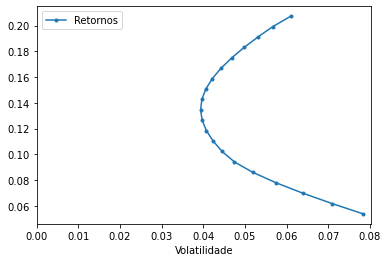

In [10]:
l = ["IBOV", "OURO_BRL", "S&P500_BRL"]
ax = plot_front_ef_v2(20, retornos_anualizado[l].values, cov_retornos.loc[l,l])
ax.set_xlim(left = 0)

In [11]:
def msr(taxa_sem_risco, rets, cov):
    """
    Retorna os pesos do portfólio que fornece o ponto Max Sharpe Ratio
    dada a taxa livre de risco, os retornos esperados e uma matriz de covariância
    """
    n = rets.shape[0]
    palpite_ini = np.repeat(1/n, n)
    limites = ((0.0, 1.0),) * n # uma N-tupla de 2-tuplas!
    #construir as restrições
    pesos_somar_ate_1 = {'type': 'eq',
                        'fun': lambda pesos: np.sum(pesos) - 1
    }
    def neg_sharpe(pesos, taxa_sem_risco, rets, cov):
        """
        Retorna o negativo do Sharpe Ratio
        da carteira indicada
        """
        r = portfolio_ret(pesos, rets)
        vol = portfolio_vol(pesos, cov)
        return -(r - taxa_sem_risco)/vol
    
    pesos = minimize(neg_sharpe, palpite_ini,
                       args=(taxa_sem_risco, rets, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(pesos_somar_ate_1,),
                       bounds=limites)
    return pesos.x

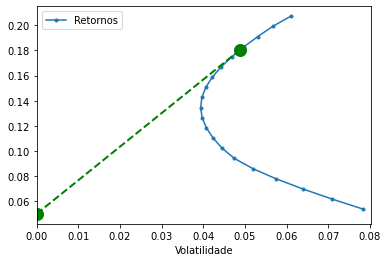

In [12]:
ax = plot_front_ef_v2(20, retornos_anualizado[l].values, cov_retornos.loc[l,l])
ax.set_xlim(left = 0)

tsr = 0.05
w_msr = msr(tsr, retornos_anualizado[l].values, cov_retornos.loc[l,l])
r_msr = portfolio_ret(w_msr, retornos_anualizado[l].values)
vol_msr = portfolio_vol(w_msr, cov_retornos.loc[l,l])

cml_x = [0, vol_msr]
cml_y = [tsr, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [13]:
r_msr, vol_msr

(0.1801445752510893, 0.048732744500400084)

In [14]:
def plot_front_ef_v3(n_ptos, rets, cov, cml=False, tsr=0.05):
    """
    Plota a fronteira eficiente de N ativos
    """

    pesos = otimizador_pesos(n_ptos, rets, cov) 
    rets_ = [portfolio_ret(w, rets) for w in pesos]
    vols_ = [portfolio_vol(w, cov) for w in pesos]
    ef = pd.DataFrame({
        "Retornos": rets_, 
        "Volatilidade": vols_
    })
    ax = ef.plot.line(x="Volatilidade", y="Retornos", style=".-")
    if cml:
        ax.set_xlim(left = 0)
        w_msr = msr(tsr, retornos_anualizado[l].values, cov_retornos.loc[l,l])
        r_msr = portfolio_ret(w_msr, retornos_anualizado[l].values)
        vol_msr = portfolio_vol(w_msr, cov_retornos.loc[l,l]) 
        cml_x = [0, vol_msr]
        cml_y = [tsr, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
    
    return ax

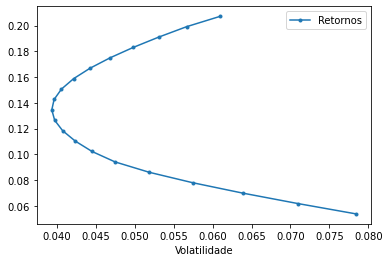

In [15]:
ax = plot_front_ef_v3(20, retornos_anualizado[l].values, cov_retornos.loc[l,l])

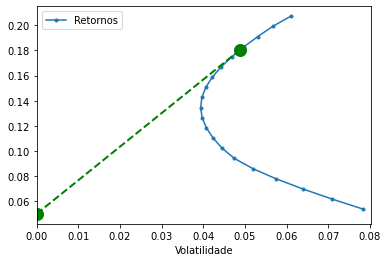

In [16]:
ax = plot_front_ef_v3(20, retornos_anualizado[l].values, cov_retornos.loc[l,l], cml=True)

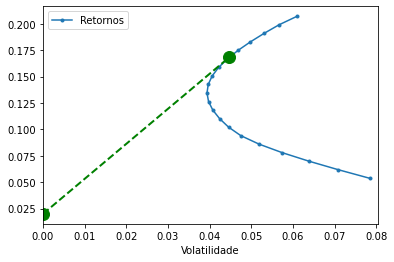

In [17]:
ax = plot_front_ef_v3(20, retornos_anualizado[l].values, cov_retornos.loc[l,l], cml=True, tsr=0.02)